In [1]:
import hashlib
import os
import re
import sys
import tarfile
from dataclasses import dataclass
import requests
import torch as t
import transformers
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from tqdm.auto import tqdm

IMDB_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_FOLDER = "./data/w2d2/"
IMDB_PATH = os.path.join(DATA_FOLDER, "acllmdb_v1.tar.gz")
SAVED_TOKENS_PATH = os.path.join(DATA_FOLDER, "tokens.pt")
device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [2]:
def maybe_download(url: str, path: str) -> None:
    """
    Download the file from url and save it to path. If path already exists, do nothing.
    """
    if os.path.exists(path):
        return
    r = requests.get(url)
    with open(path, 'wb') as f:
        f.write(r.content)
    
os.makedirs(DATA_FOLDER, exist_ok=True)
expected_hexdigest = "7c2ac02c03563afcf9b574c7e56c153a"
maybe_download(IMDB_URL, IMDB_PATH)
with open(IMDB_PATH, 'rb') as f:
    actual_hexdigest = hashlib.md5(f.read()).hexdigest()
    assert actual_hexdigest == expected_hexdigest

In [3]:
!ls data/w2d2

acllmdb_v1.tar.gz


In [4]:
@dataclass(frozen = True)
class Review:
    split: str
    is_positive: bool
    stars: int
    text: str
        
def load_reviews(path: str) -> list[Review]:
    reviews = []
    tarfile_ = tarfile.open(path, 'r:gz')
    for e in tqdm(tarfile_.getmembers()):
        m = re.match(r"aclImdb/(train|test)/(pos|neg)/\d+_(\d+)\.txt", e.name)
        if m is not None:
            split, posneg, stars = m.groups()
            file_ = tarfile_.extractfile(e)
            assert file_ is not None
            text = file_.read().decode('utf-8')
            reviews.append(Review(split, posneg == 'pos', int(stars), text))
    return reviews
        

reviews = []
reviews = load_reviews(IMDB_PATH)
assert sum((r.split == "train" for r in reviews)) == 25000
assert sum((r.split == "test" for r in reviews)) == 25000

  0%|          | 0/100019 [00:00<?, ?it/s]

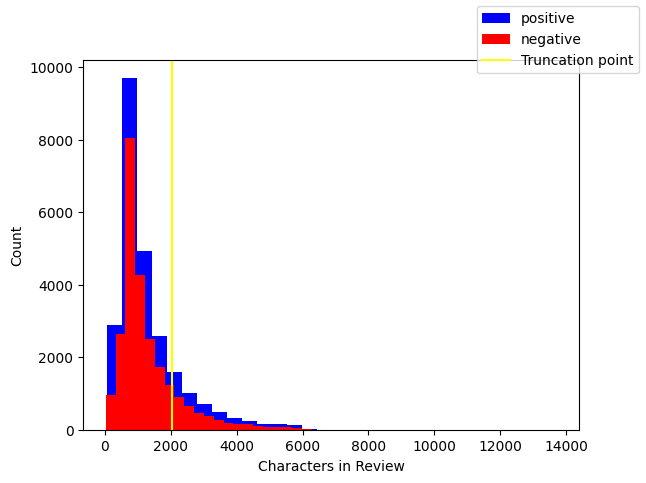

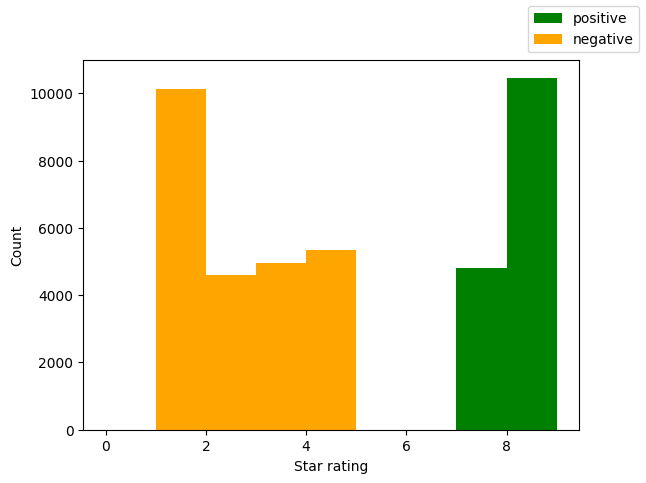

In [5]:
pos_length = [len(r.text) for r in reviews if r.is_positive]
neg_length = [len(r.text) for r in reviews if not r.is_positive]
fig, ax = plt.subplots()
ax.hist(pos_length, bins = 30, color = 'blue', label = 'positive')
ax.hist(neg_length, bins = 30, color = 'red', label = 'negative')
ax.set(xlabel = 'Characters in Review', ylabel = 'Count')
ax.axvline(2048, color="yellow", label="Truncation point")
fig.legend()

pos_star = [r.stars for r in reviews if r.is_positive]
neg_star = [r.stars for r in reviews if not r.is_positive]
fig, ax = plt.subplots()
ax.hist(pos_star, bins = range(10), color = 'green', label = 'positive')
ax.hist(neg_star, bins = range(10), color = 'orange', label = 'negative')
ax.set(xlabel="Star rating", ylabel="Count")
fig.legend()

In [6]:
def to_dataset(tokenizer, reviews: list[Review]) -> TensorDataset:
    """Tokenize the reviews (which should all belong to the same split) and bundle into a TensorDataset.
    
    The tensors in the TensorDataset should be (in the exact order):
    
    input_ids: shape (batch, sequence_length), dtype int64
    attention_mask: shape (batch, sequence_length), dtype int
    sentiment_label: shape (batch, ), dtype int
    star_labels: shape (batch, ), dtype int
    """
    tokens = tokenizer(
        [r.text for r in reviews],
        return_tensors = 'pt',
        truncation = True,
        padding = 'max_length',
    )
    
    return TensorDataset(
        tokens['input_ids'],
        tokens['attention_mask'],
        t.tensor([r.is_positive for r in reviews]),
        t.tensor([r.stars for r in reviews]),
    )
    

tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased')
train_data = to_dataset(tokenizer, [r for r in reviews if r.split == 'train'])
test_data = to_dataset(tokenizer, [r for r in reviews if r.split == 'test'])
t.save((train_data, test_data), SAVED_TOKENS_PATH)